In [1]:
from sklearn.model_selection import train_test_split

import cv2
import os, glob, natsort, re
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
#import glob, natsort

from keras.preprocessing.image import img_to_array

from keras import models, layers, regularizers
from keras.models import Sequential, Model


np.random.seed(77)

In [2]:
# Dice coefficient, IoU Metric
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + K.epsilon())
	
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [3]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 128

high_image = glob.glob('./Raw Data/high_res/*.png')
low_image = glob.glob('./Raw Data/low_res/*.png')

high_image = natsort.natsorted(high_image)
low_image = natsort.natsorted(low_image)

In [4]:
len(high_image)

855

In [5]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 128
high_img = []
path = './Raw Data/high_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '855.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img / 255.0

        img = img

        high_img.append(img_to_array(img[:, :, ::-1]))


low_img = []
path = './Raw Data/low_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
    if i == '855.jpg':
        break
    else: 
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img / 255.0

        low_img.append(img_to_array(img[:, :, ::-1]))

100%|███████████████████████████████████████████████████████████████████████████████| 855/855 [00:02<00:00, 407.78it/s]


In [6]:
from tensorflow.keras import losses, metrics, optimizers
from sklearn.model_selection import train_test_split

# high_img, low_img
x_train, x_test, y_train, y_test = train_test_split(low_img, high_img)

In [7]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [8]:
x_train.shape

(641, 128, 128, 3)

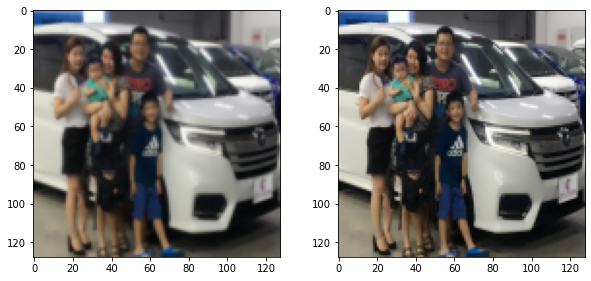

In [9]:
q = 65

plt.figure(figsize = (10, 10))

plt.subplot(221)
plt.imshow(x_train[q])

plt.subplot(222)
plt.imshow(y_train[q])

In [10]:
def conv_3x3_relu(x, n):
    x = layers.Conv2D(n, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.00001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(max_value=None, negative_slope=0, threshold=0)(x)

    return x



def Unet(a, b):
    # a = input_size
    # b = 처음에 몇 채널로 시작할지

    input = layers.Input(a)


    #Encoder

    x = conv_3x3_relu(input, b)
    down1 = conv_3x3_relu(x, b)
    x = layers.MaxPool2D(pool_size=(2, 2))(down1)


    x = conv_3x3_relu(x, b/2)
    down2 = conv_3x3_relu(x, b/2)
    x = layers.MaxPool2D(pool_size=(2, 2))(down2)


    x = conv_3x3_relu(x, b/4)
    down3 = conv_3x3_relu(x, b/4)
    x = layers.MaxPool2D(pool_size=(2, 2))(down3)


    x = conv_3x3_relu(x, b/8)
    down4 = conv_3x3_relu(x, b/8)
    drop1 = layers.Dropout(0.3)(down4)
    x = layers.MaxPool2D(pool_size=(2, 2))(drop1)




    # Bottleneck

    x = conv_3x3_relu(x, b/16)
    x = conv_3x3_relu(x, b/16)
    drop2 = layers.Dropout(0.3)(x)




    # Decoder

    up1 = layers.Conv2DTranspose(b/8, (2, 2), strides=(2, 2))(drop2)
    merge1 = layers.concatenate([down4, up1], axis=3)
    x = conv_3x3_relu(merge1, b/8)
    x = conv_3x3_relu(x, b/8)
    x = conv_3x3_relu(x, b/8)


    up2 = layers.Conv2DTranspose(b/4, (2, 2), strides=(2, 2))(x)
    merge2 = layers.concatenate([down3, up2], axis=3)
    x = conv_3x3_relu(merge2, b/4)
    x = conv_3x3_relu(x, b/4) 
    x = conv_3x3_relu(x, b/4)


    up3 = layers.Conv2DTranspose(b/2, (2, 2), strides=(2, 2))(x)
    merge3 = layers.concatenate([down2, up3], axis=3)
    x = conv_3x3_relu(merge3, b/2)
    x = conv_3x3_relu(x, b/2) 
    x = conv_3x3_relu(x, b/2)


    up4 = layers.Conv2DTranspose(b, (2, 2), strides=(2, 2))(x)
    merge4 = layers.concatenate([down1, up4], axis=3)
    x = conv_3x3_relu(merge4, b)
    x = conv_3x3_relu(x, b) 

    output = layers.Conv2D(3, (1, 1),name = 'result',activation='sigmoid')(x)

    Unet_model = models.Model(inputs=input, outputs=output)


    return Unet_model

In [11]:
model = Unet((128, 128, 3), 64)

keras.utils.multi_gpu_model?

import keras

model = keras.utils.multi_gpu_model(model, gpus = 2)

In [12]:
model.compile(optimizer = 'adam', loss = tf.keras.losses.CategoricalCrossentropy(), metrics = ('accuracy', iou, dice_coef))

In [13]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 128, 128, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [14]:
import keras
from keras.callbacks import CSVLogger

loss_callbacks = keras.callbacks.ModelCheckpoint(
                      filepath = './history/loss_1116.h5',
                      monitor = 'val_loss',
                      save_best_only = False)

acc_callbacks = keras.callbacks.ModelCheckpoint(
                      filepath = './history/acc_1116.h5',
                      monitor = 'val_accuracy',
                      save_best_only = True)

iou_callbacks = keras.callbacks.ModelCheckpoint(
                      filepath = './history/acc_1116.h5',
                      monitor = 'val_accuracy',
                      save_best_only = True)


dice_callbacks = keras.callbacks.ModelCheckpoint(
                      filepath = './history/acc_1116.h5',
                      monitor = 'val_accuracy',
                      save_best_only = True)


csv_logger = CSVLogger('./history/log_1116.csv', append=True)

In [15]:
callbacks_list = [loss_callbacks, acc_callbacks, iou_callbacks, dice_callbacks, csv_logger]

In [16]:
history = model.fit(x_train, y_train, epochs=1000, batch_size=24, validation_data=(x_test, y_test), callbacks = callbacks_list)

Epoch 1/1000
27/27 [==============================] - 148s 5s/step - loss: 1.3993 - accuracy: 0.6129 - iou: 0.4039 - dice_coef: 0.5747 - val_loss: 1.4426 - val_accuracy: 0.4904 - val_iou: 0.3345 - val_dice_coef: 0.5009
Epoch 2/1000
27/27 [==============================] - 147s 5s/step - loss: 1.3885 - accuracy: 0.7165 - iou: 0.4204 - dice_coef: 0.5915 - val_loss: 1.4412 - val_accuracy: 0.5261 - val_iou: 0.3425 - val_dice_coef: 0.5098
Epoch 3/1000
27/27 [==============================] - 147s 5s/step - loss: 1.3873 - accuracy: 0.7426 - iou: 0.4203 - dice_coef: 0.5916 - val_loss: 1.4404 - val_accuracy: 0.5647 - val_iou: 0.3398 - val_dice_coef: 0.5068
Epoch 4/1000
27/27 [==============================] - 148s 5s/step - loss: 1.3867 - accuracy: 0.7532 - iou: 0.4206 - dice_coef: 0.5918 - val_loss: 1.4399 - val_accuracy: 0.5341 - val_iou: 0.3401 - val_dice_coef: 0.5071
Epoch 5/1000
27/27 [==============================] - 148s 5s/step - loss: 1.3860 - accuracy: 0.7642 - iou: 0.4183 - dice_co

In [21]:
result_history = history.history

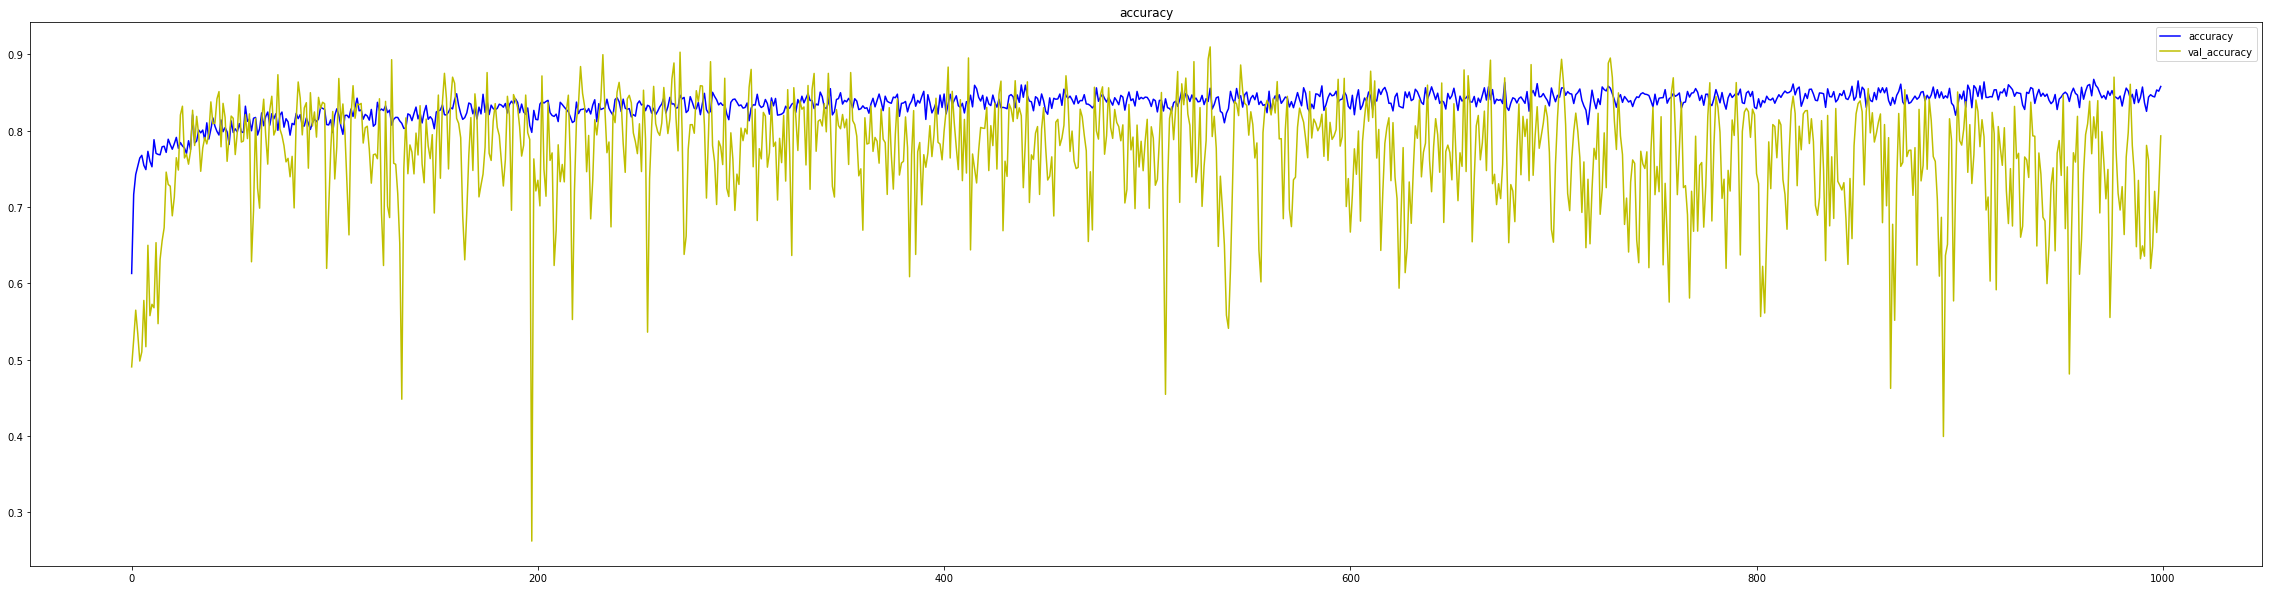

In [22]:
plt.figure(figsize = (40, 10))

plt.title('accuracy')

plt.plot(result_history['accuracy'], 'b', label = 'accuracy')
plt.plot(result_history['val_accuracy'], 'y', label = 'val_accuracy')
plt.legend()

plt.show()

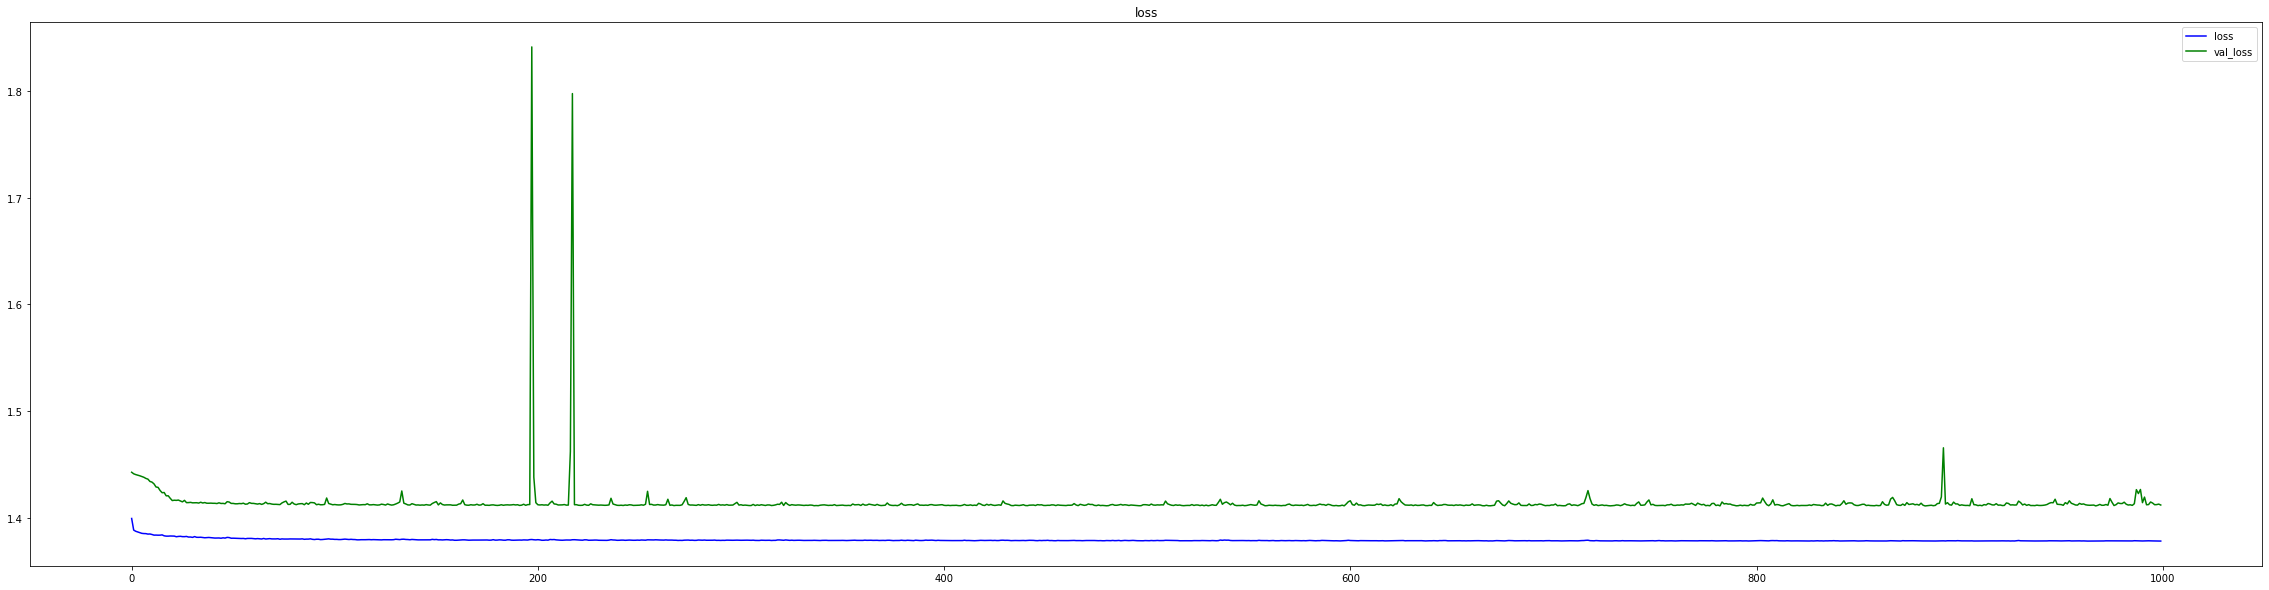

In [23]:
plt.figure(figsize = (40, 10))

plt.title('loss')
plt.plot(result_history['loss'], 'b', label = 'loss')
plt.plot(result_history['val_loss'], 'g', label = 'val_loss')

plt.legend()

plt.show()

In [24]:
import json

history_dict = history.history
json.dump(history_dict, open("./history/1000epoch_1116.json", 'w'))

model.save("./history/1000epoch_1116")
model.save_weights("./history/1000epoch_1116.h5")

INFO:tensorflow:Assets written to: ./history/1000epoch_1116\assets


## Train data로 잘 학습됐는지 test

In [50]:
model_1 = Unet((128, 128, 3), 64)
model_1.load_weights("./history/1000epoch.h5")

In [51]:
result_test = model_1.predict(x_train)

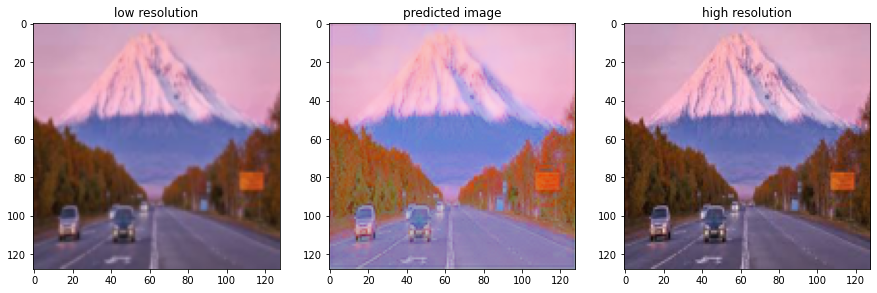

In [52]:
q = 3

plt.figure(figsize = (15, 15))



plt.subplot(231)
plt.title('low resolution')
plt.imshow(x_train[q])

plt.subplot(232)
plt.title('predicted image')
plt.imshow(result_test[q])

plt.subplot(233)
plt.title('high resolution')
plt.imshow(y_train[q])

## Test data로 실험

In [53]:
result = model_1.predict(x_test)

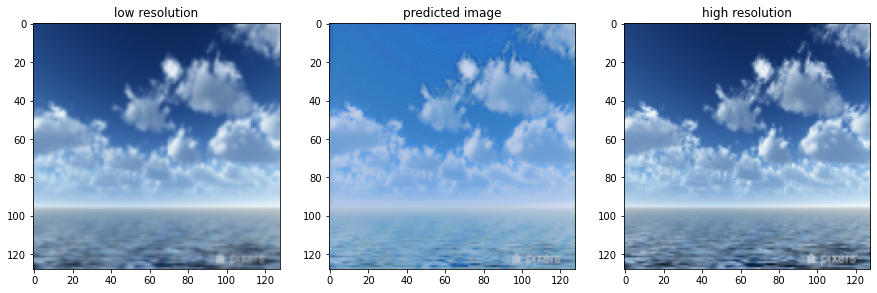

In [54]:
q = 33

plt.figure(figsize = (15, 15))



plt.subplot(231)
plt.title('low resolution')
plt.imshow(x_test[q])

plt.subplot(232)
plt.title('predicted image')
plt.imshow(result[q])

plt.subplot(233)
plt.title('high resolution')
plt.imshow(y_test[q])